# Liver Model Construction: Notebook

In [1]:
import os
import re
import warnings
from cobra.io import *
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa, qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
import sys
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [3]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")


### Getting reactions and metabolite data from RECON 3D

In [4]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_gluco_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')



# making dataframe of reactions
csv_rxn = os.path.join(data_dir,"gly_gluco_reaction_df.csv")
rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [5]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-30


In [6]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [7]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"gly_gluco_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [8]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

### Adding PPP

In [9]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"ppp_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')



# making dataframe of reactions
csv_rxn = os.path.join(data_dir,"ppp_reaction_df.csv")
rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
reaction_info = rxn_csv_df.to_dict(orient='index')

In [10]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [11]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"ppp_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [12]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [13]:
g6pase = {'g6p_c': -1, 'h2o_c': -1, 'pi_c': 1, 'glc__D_c':1}
rxn3 = cobra.Reaction('G6PP')
trial.add_reaction(rxn3)
rxn3.add_metabolites(g6pase)
trial.reactions.G6PP.lower_bound=0

In [14]:
# #adding DM_NADH 
# nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
# rxn = cobra.Reaction('DM_nadh')
# trial.add_reaction(rxn)
# rxn.add_metabolites(nadhm)




peptm = {'pep_m': -1, 'pi_c': -1, 'pi_m': 1, 'pep_c':1}
rxn2 = cobra.Reaction('PEPtm')
rxn2.lower_bound=0
trial.add_reaction(rxn2)
rxn2.add_metabolites(peptm)



# g6pase = {'g6p_c': -1, 'h2o_c': -1, 'pi_c': 1, 'glc__D_c':1}
# rxn3 = cobra.Reaction('G6PP')
# trial.add_reaction(rxn3)
# rxn3.add_metabolites(g6pase)

htm = {'h_c': -1,  'h_m': 1}
rxn4 = cobra.Reaction('Htm')
trial.add_reaction(rxn4)
rxn4.add_metabolites(htm)

# pitm = {'h_i': -1,'pi_c': -1,  'h_m': 1,  'pi_m': 1}
# rxn5 = cobra.Reaction('PItm')
# trial.add_reaction(rxn5)
# rxn5.lower_bound=0
# rxn5.add_metabolites(pitm)
# # 
# # nadph_c --> h_c + nadp_c
nadphm = {'nadph_c': -1, 'h_c': 1,  'nadp_c': 1}
rxn6 = cobra.Reaction('NADPHM')
trial.add_reaction(rxn6)
rxn6.lower_bound=0
rxn6.add_metabolites(nadphm)


In [15]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {'charge': -1.0}
PGI {}
FBP {'charge': 2.0}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PEPCKm {}
PYK {'charge': 1.0}
PCm {'charge': 1.0}
LDH_L {'charge': -1.0}
PYRt2m {}
ADK1 {}
ATPM {'charge': 1.0}
G6PDH2r {'charge': -1.0}
PGL {'charge': -1.0}
GND {}
RPI {}
RPE {}
TKT1 {}
TKT2 {}
TALA {}
G6PP {'charge': 2}
PEPtm {}
Htm {}
NADPHM {'charge': 1}


In [16]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)
escher_builder

Builder(highlight_missing=True)

In [17]:


# # Iterate through metabolites
# for mid, imbalance in imbalanced_metabolites.iteritems():
#     # Ignore balanced metabolites
#     if imbalance == 0:
#         continue
#     # Get metabolite object
#     met = new_model.metabolites.get_by_id(mid)

#     # Add boundary reactions for imbalanced metabolites
#     boundary_type = "sink"    
#     # Add boundary reaction with imbalance as flux value
#     boundary_reaction = new_model.add_boundary(
#         mid, boundary_type, boundary_condition=met.ic)

#     boundary_reaction.Keq = 1
#     if imbalance < 0:
#         boundary_reaction.reverse_stoichiometry(inplace=True)
#         imbalance = -imbalance

In [18]:
for met in ['glc__D_c',
#  'pyr_c', 
'h2o_c', 'h_c', 'pi_c',
'lac__L_c',
# 'o2_c','co2_c',
'hco3_m', 'gtp_m',

     'gdp_m',
     'co2_m' ,
         'h_m',
     'pi_m', 
    'amp_c',
    # seems to be very important (adp_m)
    'adp_m',
    'atp_m',
# 'co2_c','o2_c','o2s_c','r5p_c'
]:
    # DOUBLE CHECK PYRUVATE EXCHANGE
    rxn = cobra.Reaction('EX_%s' % met)
    
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'r5p_c' or met == 'lac__L_c' or met == 'lac__L_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [19]:
trial.metabolites.h_c.charge= 1
trial.metabolites.h_m.charge= 1
# trial.metabolites.h_i.charge= 1
trial.metabolites.pi_c.charge= -2
trial.metabolites.pi_m.charge= -2

In [20]:
trial.objective = 'ATPM'
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
FBP,0.0,-2.0
PFK,1.0,0.0
FBA,1.0,0.0
...,...,...
EX_h_m,1000.0,0.0
EX_pi_m,1000.0,1.0
EX_amp_c,0.0,0.0
EX_adp_m,500.0,0.0


In [21]:
#View all the reactions that we need build
# escher_builder = escher.Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"gly_ppp_tca.json"),highlight_missing=True)

# escher_builder

In [22]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'FBP': 0.0, 'PFK': 1.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

In [23]:
from cobra.io.json import load_json_model as load_json_cobra_model
from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob
# import cplex as cplex
# import gurobipy as gurobi

In [24]:
# glycolysis_ppp_tca_etc= load_json_cobra_model(filename=os.path.join(model_dir,"glycolysis_ppp_tca_etc_model.json"))
# R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [25]:
core_json = os.path.join(model_dir,"gly_ppp.json")
json.save_json_model(model=trial, filename=core_json)

In [26]:
for model_file in glob(core_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    #removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
    # blocked = cobra.flux_analysis.find_blocked_reactions(model)
    # print(blocked)
    # model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        # print(corr_fac)
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    ### normalise each column by the min  qty in the column
    csv_dir = os.path.join(minspan_dir,"gly_ppp_csv.csv")
    df.to_csv(csv_dir)

c:\Users\sicil\LiverModel\models\gly_ppp.json
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpdq5xzxp4.lp
Reading time = 0.00 seconds
: 41 rows, 84 columns, 248 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp9icc80bo.lp
Reading time = 0.01 seconds
: 125 rows, 126 columns, 486 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpfpuaylp7.lp
Reading time = 0.01 seconds
: 125 rows, 126 columns, 486 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpj5xbgr2m.lp
Reading time = 0.02 seconds
: 125 rows, 126 columns, 486 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpyduqig6y.lp
Reading time = 0.02 seconds
: 125 rows, 126 columns, 486 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp3w6vpuvp.lp
Reading time = 0.01 seconds
: 125 rows, 126 columns, 486 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmppkd5jgvx.lp


In [27]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_csv.csv")

In [28]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_csv.csv")
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

,0,1,2,3,4,Norm0,Norm1,Norm2,Norm3,Norm4
HEX1,0.333333,1.000000,0.0,0.5,0.0,1.0,3.0,0.0,1.0,0.0
PGI,0.333333,0.333333,0.0,0.5,0.0,1.0,1.0,0.0,1.0,0.0
FBP,0.666667,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
PFK,1.000000,0.333333,0.0,0.5,0.0,3.0,1.0,0.0,1.0,0.0
FBA,0.333333,0.333333,0.0,0.5,0.0,1.0,1.0,0.0,1.0,0.0
TPI,0.333333,0.333333,0.0,0.5,0.0,1.0,1.0,0.0,1.0,0.0
GAPD,0.666667,0.666667,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0
PGK,-0.666667,-0.666667,0.0,-1.0,0.0,-2.0,-2.0,0.0,-2.0,0.0
PGM,-0.666667,-0.666667,0.0,-1.0,0.0,-2.0,-2.0,0.0,-2.0,0.0
ENO,0.666667,0.666667,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0


In [29]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,9].iteritems()}

In [30]:
import escher
from escher import Builder

In [31]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 0.0, 'PGI': 0.0, 'FBP': 0.0, 'PFK': 0.0, 'FBA': 0.0, 'TPI': 0.0, 'GAPD': 0.0, '…

In [32]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [33]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=met_df.append(df_2)

met_df=met_df.set_index('id')

In [34]:
csv_met_cobra = os.path.join(data_dir,"gly_ppp_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [35]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df=rxn_df.append(df)

rxn_df=rxn_df.set_index('id')

In [36]:
json_rxn_cobra = os.path.join(data_dir,"gly_ppp_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra
,orient="index")

## Making MASS model of glycolysis

In [37]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [38]:
import json

In [39]:
# making dataframe of metabolites

met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

# making dataframe of reactions
# csv_rxn = os.path.join(data_dir,"glycolysis_gluconeogenesis_reaction_df.csv")
# rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
# reaction_info = rxn_csv_df.to_dict(orient='index')

In [40]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [41]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

## Setting initial conditions

In [42]:
import csv
import openpyxl

In [43]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [44]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations2.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)

In [45]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)

In [46]:
# conc_df.loc['udp_c','Concentration (M)']

In [47]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            # print(mid)
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            print(mid,ic_value)
            # row = [mid,ic_value]
            # column = [ic_value]
            met.ic =  int(ic_value)            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
adp_c 0.00199495195
atp_c 0.004727145980000001
g6p_c 0.00014000000000000001
glc__D_c 0.01048280703
f6p_c 0.00012713765
g6p_c 0.00014000000000000001
f6p_c 0.00012713765
fdp_c 5.1470825e-05
pi_c 0.0064
adp_c 0.00199495195
atp_c 0.004727145980000001
f6p_c 0.00012713765
fdp_c 5.1470825e-05
dhap_c 0.00017689737
fdp_c 5.1470825e-05
g3p_c 8.783869999999999e-06
dhap_c 0.00017689737
g3p_c 8.783869999999999e-06
13dpg_c 2.43e-07
g3p_c 8.783869999999999e-06
nad_c 0.00182530972
nadh_c 4.63542e-06
pi_c 0.0064
13dpg_c 2.43e-07
3pg_c 0.000520630485
adp_c 0.00199495195
atp_c 0.004727145980000001
2pg_c 0.000110560855
3pg_c 0.000520630485
2pg_c 0.000110560855
pep_c 0.00031
oaa_m 3.119e-05
pep_m 0.0020499999999999997
adp_c 0.00199495195
atp_c 0.004727145980000001
pep_c 0.00031
pyr_c 0.00047999999999999996
adp_m 0.008038905800000001
atp_m 0.00919
oaa_m 3.119e-05
pi_m 0.00045
pyr_m 0.00134
lac__L_c 0.00326183772
nad_c 0.00182530972
nadh_c 4.63542e-06
pyr_c 0.00047999999

In [48]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x02ad17808f70
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


### Getting Standard and Physiological Gibbs energies of reactions

In [49]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", 
# "NADHM",
#transport reactions
'NADPHM', "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm',
# these two reactions below cause issues in equilibrator
'CYOR_u10mi' , 'CYOOm2i']

# for reaction in excluded_reactions:
#     rxn=liver.reactions.get_by_id(reaction)
#     rxn.Keq=1    # Setting Keq
#     rxn.kf=1e6     # Setting kf

for rxn in liver.reactions:
    if rxn.id in excluded_reactions:
        rxn.Keq=1    # Setting Keq
        rxn.kf=1e6     # Setting kf

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

# Trying to set these as 1e6 becasue the inf might be messing with the solver
liver.reactions.ATPM.Keq=1e6
liver.reactions.NADPHM.Keq=1e6

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_pi_m: pi_m <=> 
pi_b: 0.00045

EX_amp_c: amp_c <=> 
amp_b: 0.000365

EX_adp_m: adp_m <=> 
adp_b: 0.008038905800000001

EX_atp_m: atp_m <=> 
atp_b: 0.00919



In [50]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp 

In [51]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")    

HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PEPCKm
Keq = 5.8718785452391975
PYK
Keq = 10333.2896179346
PCm
Keq = 26.659254851731617
LDH_L
Keq = 0.00013815091719569572
ADK1
Keq = 2.412316406985432e-235
G6PDH2r
Keq = 17.097653831285225
PGL
Keq = 24100.149291198326
GND
Keq = 17.168763205926346
RPI
Keq = 0.17606448521321894
RPE
Keq = 3.719491506299693
TKT1
Keq = 1.7882278915456422
TKT2
Keq = 52.46204754978471
TALA
Keq = 1.3861653927309736
G6PP
Keq = 33738.05532960206


In [52]:
# liver.reactions.CYOR_u10mi

In [53]:
# # these two reactions below cause issues in equilibrator
# weird_reactions = ['CYOR_u10mi' , 'CYOOm2i']
# for reaction in liver.reactions:
#     if reaction.id == 'CYOR_u10mi':
#         reaction_to_parse =  ("2 bigg.metabolite:h + 2 kegg:C00125 + chebi:CHEBI:64183 = 2 kegg:C00126 + kegg:C11378 + 4 bigg.metabolite:h")
      

#         rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
#         print(reaction.id)

#         #Getting Gibbs energies
#         dG0_prime = cc.standard_dg_prime(rxn_parsed)
#         print(f"ΔG'° = {dG0_prime}")
#         dGm_prime = cc.physiological_dg_prime(rxn_parsed)
#         dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
#         dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
#     #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
#         delG = dG_prime_value_in_kj_per_mol

#         # Calculating Keq from delG
#         a = exp(-delG/ (R*310.15)) 
#         reaction.Keq = a
#         print(f"Keq = {a}")
# #         list_keq=[reaction,a]
# #         rxn_keq=pd.DataFrame(list_keq)

        

In [54]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_HEX1: 4959.419292148073
Keq_PGI: 0.34798040939490554
Keq_FBP: 115004.76795942851
Keq_PFK: 1454.9063091036724
Keq_FBA: 0.1620181301040788
Keq_TPI: 0.11365701527311964
Keq_GAPD: 0.0006723795415727605
Keq_PGK: 1943.5298920087905
Keq_PGM: 0.17239894103513229
Keq_ENO: 4.332330471156045
Keq_PEPCKm: 5.8718785452391975
Keq_PYK: 10333.2896179346
Keq_PCm: 26.659254851731617
Keq_LDH_L: 0.00013815091719569572
Keq_PYRt2m: 1
Keq_ADK1: 2.412316406985432e-235
Keq_ATPM: 1000000.0
Keq_G6PDH2r: 17.097653831285225
Keq_PGL: 24100.149291198326
Keq_GND: 17.168763205926346
Keq_RPI: 0.17606448521321894
Keq_RPE: 3.719491506299693
Keq_TKT1: 1.7882278915456422
Keq_TKT2: 52.46204754978471
Keq_TALA: 1.3861653927309736
Keq_G6PP: 33738.05532960206
Keq_PEPtm: 1
Keq_Htm: 1
Keq_NADPHM: 1000000.0
Keq_EX_glc__D_c: 1
Keq_EX_h2o_c: 1
Keq_EX_h_c: 1
Keq_EX_pi_c: 1
Keq_EX_lac__L_c: 1
Keq_EX_hco3_m: 1
Keq_EX_gtp_m: 1
Keq_EX_gdp_m: 1
Keq_EX_co2_m: 1
Keq_EX_h_m: 1
Keq_EX_pi_m: 1
Keq

##  Set Fluxes

In [55]:
# liver.metabolites.o2s_c

In [56]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_csv.csv")
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

,0,1,2,3,4,Norm0,Norm1,Norm2,Norm3,Norm4
HEX1,0.333333,1.000000,0.0,0.5,0.0,1.0,3.0,0.0,1.0,0.0
PGI,0.333333,0.333333,0.0,0.5,0.0,1.0,1.0,0.0,1.0,0.0
FBP,0.666667,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
PFK,1.000000,0.333333,0.0,0.5,0.0,3.0,1.0,0.0,1.0,0.0
FBA,0.333333,0.333333,0.0,0.5,0.0,1.0,1.0,0.0,1.0,0.0
TPI,0.333333,0.333333,0.0,0.5,0.0,1.0,1.0,0.0,1.0,0.0
GAPD,0.666667,0.666667,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0
PGK,-0.666667,-0.666667,0.0,-1.0,0.0,-2.0,-2.0,0.0,-2.0,0.0
PGM,-0.666667,-0.666667,0.0,-1.0,0.0,-2.0,-2.0,0.0,-2.0,0.0
ENO,0.666667,0.666667,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0


In [57]:
import escher
from escher import Builder

In [58]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,5].iteritems()}

In [59]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'FBP': 2.0, 'PFK': 3.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

In [60]:
# independent_fluxes=[]
#     0: PDHM #lactate to pyruvate to TCA cycle
#     1: HEX1 # glycolysis
#     2: # TCA again but 2 different reactions than 0 (PEPCK_re/MDH/) 
#     3: #TCA and ETC
#     4: #glycolysis but with PFK/FBP loop
#     5: #PPP
#     6: #glycolysis with HEX1/G6PP loop
#     7: #second half of PPP with upper part of glycolysis
#     8: #TCA again with small differences (transfers maybe)
#     9: # TCA with mitochondrial bypass
 

In [61]:
# making dataframe of reactions

# csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
# minspan_df = pd.read_csv(csv_minspan_dir,index_col="rxn") 
# minspan_df

In [62]:
reaction_list=[]
for reaction in trial.reactions:
    r_id = reaction.id
    reaction_list.append(r_id)

In [63]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux    * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 1.278605
v_PGI: 1.278605
v_FBP: 0.0
v_PFK: 1.278605
v_FBA: 1.278605
v_TPI: 1.278605
v_GAPD: 2.55721
v_PGK: -2.55721
v_PGM: -2.55721
v_ENO: 2.55721
v_PEPCKm: 639.3025
v_PYK: 641.85971
v_PCm: 639.3025
v_LDH_L: -2.55721
v_PYRt2m: 639.3025
v_ADK1: 0.0
v_ATPM: 641.85971
v_G6PDH2r: 0.0
v_PGL: 0.0
v_GND: 0.0
v_RPI: 0.0
v_RPE: 0.0
v_TKT1: 0.0
v_TKT2: 0.0
v_TALA: 0.0
v_G6PP: 0.0
v_PEPtm: 639.3025
v_Htm: 0.0
v_NADPHM: 0.0
v_EX_glc__D_c: -1.278605
v_EX_h2o_c: -639.3025
v_EX_h_c: -636.7452900000001
v_EX_pi_c: 0.0
v_EX_lac__L_c: 2.55721
v_EX_hco3_m: -639.3025
v_EX_gtp_m: -639.3025
v_EX_gdp_m: 639.3025
v_EX_co2_m: 639.3025
v_EX_h_m: 1278.605
v_EX_pi_m: 1278.605
v_EX_amp_c: 0.0
v_EX_adp_m: 639.3025
v_EX_atp_m: -639.3025


In [64]:
liver.metabolites.h_c.charge= 1
# liver.metabolites.h_i.charge= 1
liver.metabolites.h_m.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2
liver.metabolites.pi_m.charge= -2

## Set H2O/H Constants

In [65]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
    # 'h_i',
     'h_m', 
    
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
    # 'h2o_m', 
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c', 'pi_m'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [66]:
for metabolite in [
#     'h_m',
# 'h_i',
 'h_m',
"h_c", 
   # 'o2_m', 
   # 'o2_c', 
#     'h_e',
"h2o_c",
# 'h2o_m'
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [67]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            # print(mid)
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            print(mid,ic_value)
            # row = [mid,ic_value]
            # column = [ic_value]
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
adp_c 0.00199495195
atp_c 0.004727145980000001
g6p_c 0.00014000000000000001
glc__D_c 0.01048280703
f6p_c 0.00012713765
g6p_c 0.00014000000000000001
f6p_c 0.00012713765
fdp_c 5.1470825e-05
pi_c 0.0064
adp_c 0.00199495195
atp_c 0.004727145980000001
f6p_c 0.00012713765
fdp_c 5.1470825e-05
dhap_c 0.00017689737
fdp_c 5.1470825e-05
g3p_c 8.783869999999999e-06
dhap_c 0.00017689737
g3p_c 8.783869999999999e-06
13dpg_c 2.43e-07
g3p_c 8.783869999999999e-06
nad_c 0.00182530972
nadh_c 4.63542e-06
pi_c 0.0064
13dpg_c 2.43e-07
3pg_c 0.000520630485
adp_c 0.00199495195
atp_c 0.004727145980000001
2pg_c 0.000110560855
3pg_c 0.000520630485
2pg_c 0.000110560855
pep_c 0.00031
oaa_m 3.119e-05
pep_m 0.0020499999999999997
adp_c 0.00199495195
atp_c 0.004727145980000001
pep_c 0.00031
pyr_c 0.00047999999999999996
adp_m 0.008038905800000001
atp_m 0.00919
oaa_m 3.119e-05
pi_m 0.00045
pyr_m 0.00134
lac__L_c 0.00326183772
nad_c 0.00182530972
nadh_c 4.63542e-06
pyr_c 0.00047999999

In [68]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=liver,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)

In [69]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
    'h_i', 'h_m',
    # 'o2_m', 'o2_c', 
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",'h2o_m',
        
#     "pi_e",
    # "glc__D_e",
#  "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        
# 'NADPHM',
 "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm'
        
        
    #     "Ht", "H2Ot", "H2Oter",'PIter','PIt',
    # 'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

mass\thermo\conc_solver.py:252 UserWarning: Could not set `excluded_metabolites` due to the following: Invalid metabolite identifiers in ['h_i', 'h2o_m']
mass\thermo\conc_solver.py:252 UserWarning: Could not set `excluded_reactions` due to the following: Invalid reaction identifiers in ['Htmi', 'MALtm', 'ATPtm', 'AKGMALtm', 'O2tm', 'H2Otm', 'CO2tm', 'PItm']
['FBP', 'ADK1', 'G6PDH2r', 'PGL', 'GND', 'RPI', 'RPE', 'TKT1', 'TKT2', 'TALA', 'G6PP', 'Htm', 'NADPHM', 'EX_pi_c', 'EX_amp_c']
['FBP', 'ADK1', 'G6PDH2r', 'PGL', 'GND', 'RPI', 'RPE', 'TKT1', 'TKT2', 'TALA', 'G6PP', 'Htm', 'NADPHM', 'EX_pi_c', 'EX_amp_c']


,variables,reduced_costs
adp_c,0.001995,0.000000
atp_c,0.004727,0.000000
g6p_c,0.000269,0.000000
glc__D_c,0.010483,0.000000
h_c,1.000000,1.674173
...,...,...
Keq_EX_co2_m,2.913108,0.000000
Keq_EX_h_m,2.718282,0.000000
Keq_EX_pi_m,6040.626285,0.000000
Keq_EX_adp_m,18.388604,0.000000


In [70]:
conc_info=pd.DataFrame(columns=['met','conc'])
for met in liver.metabolites:
    conc_info.loc[len(conc_info.index)] = [met.id, met.ic]
conc_info = conc_info.set_index('met')
conc_info

,conc
met,
adp_c,1.994952e-03
atp_c,4.727146e-03
g6p_c,1.400000e-04
glc__D_c,1.048281e-02
h_c,1.000000e+00
f6p_c,1.271376e-04
fdp_c,5.147082e-05
h2o_c,1.000000e+00
pi_c,6.400000e-03


In [71]:
keq_info=pd.DataFrame(columns=['reaction','Keq_H'])
irreverisble=['PYK', 'HEX1', 'PFK', 'PYRt2m', 'ATPM', 'NADHM', 'PEPtm']
for rxn in liver.reactions:
    if rxn not in liver.boundary and rxn.id not in irreverisble:
        keq_info.loc[len(keq_info.index)] = [(
            "Keq_"+
        rxn.id), rxn.Keq]
keq_info = keq_info.set_index('reaction')
keq_info

,Keq_H
reaction,
Keq_PGI,3.479804e-01
Keq_FBP,1.150048e+05
Keq_FBA,1.620181e-01
Keq_TPI,1.136570e-01
Keq_GAPD,6.723795e-04
Keq_PGK,1.943530e+03
Keq_PGM,1.723989e-01
Keq_ENO,4.332330e+00
Keq_PEPCKm,5.871879e+00


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'nadph_c', 'gtp_m', '6pgl_c', 'gdp_m', '6pgc_c', 'co2_c', 'co2_m', 'hco3_m'}, only in one set of given values


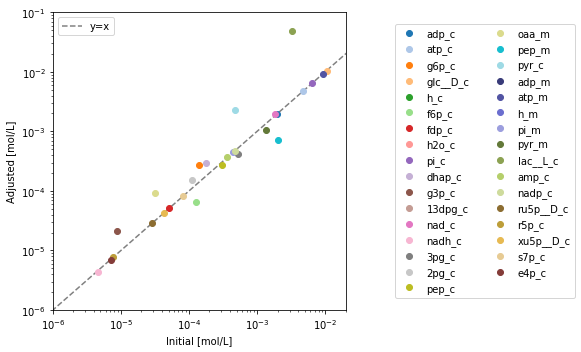

In [72]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_info['conc'], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()


In [73]:
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True)

Name,Core_Model
Memory address,0x02ad14076910
Stoichiometric Matrix,41x43
Matrix Rank,38
Number of metabolites,41
Initial conditions defined,41/41
Number of reactions,43
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [74]:
for k, v in conc_solution.Keqs.items():
    keq_info.loc[k,"Keq_cs"]= v
keq_info = keq_info.reset_index()
keq_info

,reaction,Keq_H,Keq_cs
0,Keq_PGI,3.479804e-01,0.668626
1,Keq_FBP,1.150048e+05,NaN
2,Keq_FBA,1.620181e-01,0.162018
3,Keq_TPI,1.136570e-01,0.191124
4,Keq_GAPD,6.723795e-04,0.002692
5,Keq_PGK,1.943530e+03,1943.529892
6,Keq_PGM,1.723989e-01,0.137497
7,Keq_ENO,4.332330e+00,4.850113
8,Keq_PEPCKm,5.871879e+00,17.105415
9,Keq_PCm,2.665925e+01,26.659255


In [90]:
# scatter plot encodings shared by all marks
plot = alt.Chart(keq_info).mark_circle(size=40).encode(
    alt.X('Keq_H:Q', scale=alt.Scale(type ='log'),axis=alt.Axis(grid = False)),
    alt.Y('Keq_cs:Q', scale=alt.Scale(type ='log'),axis=alt.Axis(grid = False)),
    alt.Color('reaction:N',scale=alt.Scale(scheme='turbo')),
    tooltip = 'reaction:N'
).interactive()

# rule = (
#     alt.Chart().mark_rule(strokeDash=[12, 6], size=1).encode(x=1.150048e+05, y=1.150048e+05)
# )
plot
# +rule

alt.Chart(...)

In [76]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=liver,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)

escher_builder

Builder(highlight_missing=True)

In [77]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
                or r== liver.reactions.PYRt2m
                or r== liver.reactions.PEPtm
                # or r== liver.reactions.Htmi
                # or r== liver.reactions.MALtm
                # or r== liver.reactions.ATPtm
                # or r== liver.reactions.AKGMALtm
                # or r== liver.reactions.O2tm
                # or r== liver.reactions.H2Otm
                # or r== liver.reactions.CO2tm
                # or r== liver.reactions.PItm
                or r== liver.reactions.Htm
            
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 25802.437897
kf_PGI: 7519.341979
kf_FBP: 100000.000000
kf_PFK: 4088743.058636
kf_FBA: 24859.901474
kf_TPI: 6799.791485
kf_GAPD: 15356251812.631134
kf_PGK: 2876932060.501747
kf_PGM: 3584.138074
kf_ENO: 26067.084954
kf_PEPCKm: 10386577.785045
kf_PYK: 1164100731.618228
kf_PCm: 1641080383512.445557
kf_LDH_L: 15475.727680
kf_PYRt2m: 1000000.000000
kf_ADK1: 100000.000000
kf_ATPM: 135781.656511
kf_G6PDH2r: 100000.000000
kf_PGL: 100000.000000
kf_GND: 100000.000000
kf_RPI: 100000.000000
kf_RPE: 100000.000000
kf_TKT1: 100000.000000
kf_TKT2: 100000.000000
kf_TALA: 100000.000000
kf_G6PP: 100000.000000
kf_PEPtm: 1000000.000000
kf_Htm: 1000000.000000
kf_NADPHM: 100000.000000
kf_EX_glc__D_c: 1000000.000000
kf_EX_h2o_c: 1000000.000000
kf_EX_h_c: 1000000.000000
kf_EX_pi_c: 1000000.000000
kf_EX_lac__L_c: 1000000.000000
kf_EX_hco3_m: 1000000.000000
kf_EX_gtp_m: 1000000.000000
kf_EX_gdp_m: 1000000.000000
kf_EX_co2_m: 1000000.000000
kf_EX_h_m: 1000000.

In [78]:
# conc_solution.concentrations.co2_c
conc_solution.concentrations.hco3_m

6.350548861722487e-05

In [79]:
liver.boundary_conditions['h2o_b']=1 ##M # from HEPATOKIN conc
liver.boundary_conditions['h_b']=0.0064 ##M # from HEPATOKIN conc
liver.boundary_conditions['co2_b']=9.999999999999996e-11# from conc_solver
liver.boundary_conditions['o2s_b']=9.999999999999996e-11
liver.boundary_conditions['o2_b']=1.0 # from conc_solver
liver.boundary_conditions['gdp_b']=0.9331209144774273 # from conc_solver
liver.boundary_conditions['gtp_b']=1.0716724751154323 # from conc_solver
liver.boundary_conditions['hco3_b']=6.350548861722487e-05 # from conc_solver



In [80]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [81]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [82]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Core_Model                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ---------------------                        │
│ NADPHM: {charge: 2.0}                        │
│ ============================================ │
╘══════════════════════════════════════════════╛


In [83]:
from roadrunner import __version__
__version__

'2.1.3'

In [84]:
# from mass.util.matrix import eig
# from mass.util.matrix import jacobian

In [85]:
# jac= jacobian(liver)

# jac

In [86]:
# eigen= eig(jac)
# eigen

In [87]:
# eig(liver.stoichiometric_matrix, right=True)

In [88]:
# liver.update_S(array_type="DataFrame", dtype=int)
simG.integrator.max_iter

NameError: name 'simG' is not defined

In [ ]:
simG=Simulation(liver, verbose=True)
# simG.integrator.minimum_time_step=1e-15
# simG.integrator.maximum_time_step=1e1
simG.integrator.maximum_num_steps=1e3
# simG.integrator.initial_time_step=1e-12

# conc_sol, flux_sol = simG.find_steady_state(liver, strategy="simulate")
# for metabolite, solution in conc_sol.items():
#     print("{0}: {1}".format(metabolite, solution))


conc_sol, flux_sol = simG.find_steady_state(liver, strategy="simulate")
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

In [ ]:
print(simG.integrator)

In [ ]:
# Setup simulation object


# simG.integrator.maximum_time_step= 1000
# Simulate from 0 to 1000 with 10001 points in the output
# simG.time_step
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e3),interpolate=True)
# Quickly render and display time profiles
# conc_sol.view_time_profile()